# Elektronska fiskalizacija racuna

### Priprema okruzenja

Run `pip install -r requirements.txt` to install: **jupyter**, **signxml**, **pycrypto**, **requests**, **pytz**, **xmltodict**, **pillow**, **qrcode**, **jinja2**

In [1]:
# !pip install -r requirements.txt

### Priprema sertifikata

In [2]:
# Naziv fajla sertifikata
pfx_cert = 'CoreitPecatSoft.pfx'
# Lozinka sertifikata
pfx_password = b'123456'

Ekstrakcija privatnog kljuca i sertifikata iz PFX kontejnera.

In [3]:
import OpenSSL.crypto
import os

def write_CAs(filename, p12):
    if os.path.exists(filename):
        os.remove(filename)
    ca = p12.get_ca_certificates()
    if ca is None:
        return
    print('Creating Certificate CA File:', filename)
    with open(filename, 'wb') as f:
        for cert in ca:
            f.write(OpenSSL.crypto.dump_certificate(OpenSSL.crypto.FILETYPE_PEM, cert))

def pfx_to_pem(pfx_path, pfx_password, pkey_path, pem_path, pem_ca_path):
    print('Opening:', pfx_path)
    with open(pfx_path, 'rb') as f_pfx:
        pfx = f_pfx.read()
    print('Loading P12 (PFX) contents:')
    p12 = OpenSSL.crypto.load_pkcs12(pfx, pfx_password)
    print('Creating Private Key File:', pkey_path)
    with open(pkey_path, 'wb') as f:
        f.write(OpenSSL.crypto.dump_privatekey(OpenSSL.crypto.FILETYPE_PEM, p12.get_privatekey()))
    print('Creating Certificate File:', pem_path)
    with open(pem_path, 'wb') as f:
        f.write(OpenSSL.crypto.dump_certificate(OpenSSL.crypto.FILETYPE_PEM, p12.get_certificate()))
    write_CAs(pem_ca_path, p12)

pfx_to_pem(
    pfx_cert,
    pfx_password,
    'coreit.key',      # Filename to write private key
    'coreit_cert.pem', # Filename to write certificate
    'coreit_ca.pem')   # Filename to write CAs if present

Opening: CoreitPecatSoft.pfx
Loading P12 (PFX) contents:
Creating Private Key File: coreit.key
Creating Certificate File: coreit_cert.pem
Creating Certificate CA File: coreit_ca.pem


C:\Users\Djordje\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: PKCS#12 support in pyOpenSSL is deprecated. You should use the APIs in cryptography.


### Priprema podataka

#### Osnovni podaci poreskog obveznika

In [4]:
taxpayer = {
    'tin': '12345678',  # Taxpayers tax identification number (PIB/JMB)
    'bu': 'xx123xx123', # Business unit code (PJ)
    'cr': 'si747we972', # ENU code
    'sw': 'ss123ss123', # ENU software code
    'op': 'oo123oo123'  # Operator code
}

#### Osnovni podaci fakture

##### Zaglavlje

In [5]:
invoice = {
    'ord': '1', # Invoice ordinal number (1, 2, 3, 4, ...)
    'prc': None # Total invoice price (bice rekalkulisano, mogu ostati nule)
}

##### Stavke fakture

In [6]:
# Deklarisanje tabele
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
invoice_items = pd.DataFrame({
    'N': [], # Name of item (goods or services)
    'C': [], # Code of the item from the barcode or similar representation
    'U': [], # Unit of measure
    'Q': [], # Quantity
    'UPB': [], # Unit price before VAT is applied
    'UPA': [], # Unit price after VAT is applied
    'R': [], # Percentage of the rebate
    'RR': [], # Is rebate reducing tax base amount? (true)
    'PB': [], # Total price of goods and services before the tax
    'VR': [], # VAT Rate
    'VA': [], # Amount of VAT for goods and services
    'PA': [], # Price after applying VAT
})

# Dodavanje stavki
invoice_items = invoice_items.append({
    'N': 'Test artikal',
    'C': '1234234',
    'U': 'kom',
    'Q': 1,
    'UPB': 14.17,
    'UPA': None,
    'R': 15,
    'RR': 'true',
    'PB': None,
    'VR': 21.00,
    'VA': None,
    'PA': None
}, ignore_index=True)

# Kalkulacija
invoice_items['UPA'] = invoice_items['UPB'] * (1 + invoice_items['VR'] / 100)
invoice_items['PB'] = invoice_items['UPB'] * invoice_items['Q']
invoice_items['PA'] = invoice_items['UPA'] * invoice_items['Q']
invoice_items['VA'] = invoice_items['PA'] - invoice_items['PB']

invoice['prc'] = "%.2f" % invoice_items[['PA']].sum()[0]

##### Pregled stavki faktura

In [7]:
invoice_items

,N,C,U,Q,UPB,UPA,R,RR,PB,VR,VA,PA
0,Test artikal,1234234,kom,1.00,14.17,17.15,15.00,true,14.17,21.00,2.98,17.15


##### Rekapitulacija PDV-a

In [8]:
taxes = invoice_items.groupby(['VR']).agg(NumOfItems = ('N', 'count'), PriceBefVAT = ('PB', 'sum'), VATAmt = ('VA', 'sum')).reset_index()
taxes.rename(columns={'VR': 'VATRate'}, inplace=True)
taxes

,VATRate,NumOfItems,PriceBefVAT,VATAmt
0,21.00,1,14.17,2.98


## Fiskalizacija

#### Generisanje UUID-a (jedinstvenog ID-a)

In [9]:
import uuid
fresh_uuid = str(uuid.uuid4())
fresh_uuid

'f223ea2c-eb26-4f61-a264-b8a47779e250'

#### Odredjivanje datuma i vremena

In [10]:
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Europe/Podgorica')).strftime('%Y-%m-%dT%H:%M:%S%z')
current_time = "{0}:{1}".format(current_time[:-2], current_time[-2:])
current_time

'2021-10-13T14:22:13+02:00'

#### Generisanje IKOF-a

In [11]:
import hashlib
import sys
import time

from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_v1_5 as Cipher_PKCS1_v1_5
from Crypto.Signature import PKCS1_v1_5
from base64 import b64decode, b64encode
from Crypto.Hash import SHA256

if sys.version_info >= (3, 8):
    time.clock = time.process_time

def generate_iis(data, private_key_path):
    print('IKOF data element:', data)
    message = bytes(data, 'utf8')
    digest = SHA256.new()
    digest.update(message)    
    private_key = False
    with open(private_key_path, "r") as key_file:
        private_key = RSA.importKey(key_file.read())
    signer = PKCS1_v1_5.new(private_key)
    sig = signer.sign(digest)
    iic = hashlib.md5(sig).digest()
    
    return (sig.hex(), iic.hex())

(iic, ikof) = generate_iis(
    "{tin}|{current_time}|{no}|{bu}|{cr}|{sw}|{prc}".format(
        tin = taxpayer['tin'],
        current_time = current_time,
        no = invoice['ord'],
        bu = taxpayer['bu'],
        cr = taxpayer['cr'],
        sw = taxpayer['sw'],
        prc = invoice['prc']
    ),
    'coreit.key'
)
print("IKOF:", ikof)

IKOF data element: 12345678|2021-10-13T14:22:13+02:00|1|xx123xx123|si747we972|ss123ss123|17.15
IKOF: f108325b48e89a416d69a551f1c3ff34


### Priprema XML-a

#### Priprema XML objekta i parsiranje XML sadrzaja

In [12]:
# Priprema niza Invoice Items za umetanje u XML
ii = invoice_items.rename(columns = lambda x: '@' + x)
ii = ii.to_dict('records')
tx = taxes.rename(columns = lambda x: '@' + x)
tx = tx.to_dict('records')
for item in ii:
    item['@Q'] = '{:.2f}'.format(item['@Q'])
    item['@UPB'] = '{:.2f}'.format(item['@UPB'])
    item['@UPA'] = '{:.2f}'.format(item['@UPA'])
    item['@R'] = '{:.2f}'.format(item['@R'])
    item['@PB'] = '{:.2f}'.format(item['@PB'])
    item['@VR'] = '{:.2f}'.format(item['@VR'])
    item['@VA'] = '{:.2f}'.format(item['@VA'])
    item['@PA'] = '{:.2f}'.format(item['@PA'])

for item in tx:
    item['@VATRate'] = '{:.2f}'.format(item['@VATRate'])
    item['@PriceBefVAT'] = '{:.2f}'.format(item['@PriceBefVAT'])
    item['@VATAmt'] = '{:.2f}'.format(item['@VATAmt'])

In [13]:
# Formiranje dictionary objekta sa podacima za XML fajl
xmldata = {
    'RegisterInvoiceRequest': {
        '@xmlns:xsd': 'http://www.w3.org/2001/XMLSchema',
        '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        '@xmlns': 'https://efi.tax.gov.me/fs/schema',
        '@Id': 'Request',
        '@Version': '1',
        'Header': {
            '@SendDateTime': current_time,
            '@UUID': fresh_uuid            
        },
        'Invoice': {
            '@BusinUnitCode': taxpayer['bu'],
            '@IssueDateTime': current_time,
            '@IIC': ikof,
            '@IICSignature': iic,
            '@InvNum': '{0}/{1}/{2}/{3}'.format(taxpayer['bu'], invoice['ord'], datetime.now().year, taxpayer['cr']),
            '@InvOrdNum': invoice['ord'],
            '@IsIssuerInVAT': 'true',
            '@IsReverseCharge': 'false',
            '@InvType': 'INVOICE',
            '@OperatorCode': taxpayer['op'],
            '@SoftCode': taxpayer['sw'],
            '@TCRCode': taxpayer['cr'], # ENU code
            '@TotPrice': "%.2f" % invoice_items[['PA']].sum()[0],
            '@TotPriceWoVAT': "%.2f" % invoice_items[['PB']].sum()[0],
            '@TotVATAmt': "%.2f" % invoice_items[['VA']].sum()[0],
            '@TypeOfInv': 'NONCASH',
            'PayMethods': {
                'PayMethod': {
                    '@Amt': "%.2f" % invoice_items[['PA']].sum()[0],
                    '@Type': 'ACCOUNT'
                }
            },
            'Seller': {
                '@IDType': 'TIN',
                '@IDNum': '12345678',
                '@Name': 'Test d.o.o.'
            },
            'Buyer': {
                '@IDType': 'TIN',
                '@IDNum': '12345678',
                '@Name': 'Test d.o.o'
            },
            'Items': {
                'I': ii
            },
            'SameTaxes': {
                'SameTax': tx
            }
        }
    }
}

# Konverzija u XML format za parsiranje u etree objekat
import xmltodict
xml = xmltodict.unparse(xmldata)

# etree ne voli encoding zapis, pa se on uklanja iz XML-a
xml = xml.replace(' encoding="utf-8"', '')

from lxml import etree
xml_obj = etree.fromstring(xml)

print(etree.tostring(xml_obj, encoding='utf8', pretty_print=1).decode('utf8'))

<RegisterInvoiceRequest xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="https://efi.tax.gov.me/fs/schema" Id="Request" Version="1">
  <Header SendDateTime="2021-10-13T14:22:13+02:00" UUID="f223ea2c-eb26-4f61-a264-b8a47779e250"/>
  <Invoice BusinUnitCode="xx123xx123" IssueDateTime="2021-10-13T14:22:13+02:00" IIC="f108325b48e89a416d69a551f1c3ff34" IICSignature="2fa646e3d77672efce0f72f948ac250c763de7289ab2c854d753b0275754d1c4f0404656f4f5f64d707742ce636355510f4d70271d7c0c31efc45cc1cc66cec894772a0fcaf89d2be5ea3c582394a2f49d8688ddc1be5a7a0b85874a1d55c30b6e64eb995684430e0dd33999b865f56b1599a3a268c11b1d9c044b33887e8fd00d1a9c0f82bdf4f2cf3789db3046de9ad9f09bb24aad537222f1cbe27594c64abca1ca4165d6b49d25814402ed8a157157551afb06320467d7e75f4e708bf2655f159179ff02e59e7ff6eff03aa00ef4a9b0853f793e931c55a7ad0157be66b727640013d5109b95d20d1b4a7200c7ffc8da0f664cfcd63df9416d33ed18ad0b" InvNum="xx123xx123/1/2021/si747we972" InvOrdNum="1" IsIssuerInVAT=

#### Potpisivanje

In [14]:
from lxml import etree
from signxml import XMLSigner, XMLVerifier, methods

cert = open("coreit_cert.pem", 'rb').read()
key = open("coreit.key", 'rb').read()

signer = XMLSigner(
    method = methods.enveloped,
    signature_algorithm = 'rsa-sha256',
    digest_algorithm = 'sha256',
    c14n_algorithm = 'http://www.w3.org/2001/10/xml-exc-c14n#'
)

# Uklanjanje suvisnih DS namespace prefix-a
ns = {}
ns[None] = signer.namespaces['ds']
signer.namespaces = ns

# Konacno potpisivanje
signed_xml = signer.sign(
    xml_obj, 
    key=key,
    cert=cert
)

print(etree.tostring(signed_xml, encoding='utf8').decode('utf8'))

<RegisterInvoiceRequest xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="https://efi.tax.gov.me/fs/schema" Id="Request" Version="1"><Header SendDateTime="2021-10-13T14:22:13+02:00" UUID="f223ea2c-eb26-4f61-a264-b8a47779e250"/><Invoice BusinUnitCode="xx123xx123" IssueDateTime="2021-10-13T14:22:13+02:00" IIC="f108325b48e89a416d69a551f1c3ff34" IICSignature="2fa646e3d77672efce0f72f948ac250c763de7289ab2c854d753b0275754d1c4f0404656f4f5f64d707742ce636355510f4d70271d7c0c31efc45cc1cc66cec894772a0fcaf89d2be5ea3c582394a2f49d8688ddc1be5a7a0b85874a1d55c30b6e64eb995684430e0dd33999b865f56b1599a3a268c11b1d9c044b33887e8fd00d1a9c0f82bdf4f2cf3789db3046de9ad9f09bb24aad537222f1cbe27594c64abca1ca4165d6b49d25814402ed8a157157551afb06320467d7e75f4e708bf2655f159179ff02e59e7ff6eff03aa00ef4a9b0853f793e931c55a7ad0157be66b727640013d5109b95d20d1b4a7200c7ffc8da0f664cfcd63df9416d33ed18ad0b" InvNum="xx123xx123/1/2021/si747we972" InvOrdNum="1" IsIssuerInVAT="true"

#### Formiranje SOAP zahtjeva

In [15]:
soap_ns = 'http://schemas.xmlsoap.org/soap/envelope/'
ns_map = {'SOAP-ENV': soap_ns}

envelope = etree.Element(etree.QName(soap_ns, 'Envelope'), nsmap=ns_map)
header = etree.SubElement(envelope, etree.QName(soap_ns, 'Header'), nsmap=ns_map)
body = etree.SubElement(envelope, etree.QName(soap_ns, 'Body'), nsmap=ns_map)

reg_invoice_req = body.append(signed_xml)
#soap_request = etree.tostring(envelope, encoding='utf8', pretty_print=1)
soap_request = etree.tostring(envelope, encoding='utf8')

print(soap_request.decode('utf8'))

<SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/"><SOAP-ENV:Header/><SOAP-ENV:Body><RegisterInvoiceRequest xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="https://efi.tax.gov.me/fs/schema" Id="Request" Version="1"><Header SendDateTime="2021-10-13T14:22:13+02:00" UUID="f223ea2c-eb26-4f61-a264-b8a47779e250"/><Invoice BusinUnitCode="xx123xx123" IssueDateTime="2021-10-13T14:22:13+02:00" IIC="f108325b48e89a416d69a551f1c3ff34" IICSignature="2fa646e3d77672efce0f72f948ac250c763de7289ab2c854d753b0275754d1c4f0404656f4f5f64d707742ce636355510f4d70271d7c0c31efc45cc1cc66cec894772a0fcaf89d2be5ea3c582394a2f49d8688ddc1be5a7a0b85874a1d55c30b6e64eb995684430e0dd33999b865f56b1599a3a268c11b1d9c044b33887e8fd00d1a9c0f82bdf4f2cf3789db3046de9ad9f09bb24aad537222f1cbe27594c64abca1ca4165d6b49d25814402ed8a157157551afb06320467d7e75f4e708bf2655f159179ff02e59e7ff6eff03aa00ef4a9b0853f793e931c55a7ad0157be66b727640013d5109b95d20d1b4a720

### Slanje SOAP zahtjeva

In [16]:
import requests
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
efi_url = 'https://efitest.tax.gov.me:443/fs-v1'
# efi_url = 'https://efi.tax.gov.me/fs-v1'

headers = {'content-type': 'text/xml'}

response = requests.post(efi_url, data=soap_request,headers=headers, verify=False)
xml_response = etree.fromstring(response.content)

print(etree.tostring(xml_response, encoding='utf8', pretty_print=1).decode('utf8'))

<env:Envelope xmlns:env="http://schemas.xmlsoap.org/soap/envelope/">
  <env:Header/>
  <env:Body>
    <RegisterInvoiceResponse xmlns="https://efi.tax.gov.me/fs/schema" xmlns:ns0="http://www.w3.org/2000/09/xmldsig#" Id="Response" Version="1">
      <Header xmlns="https://efi.tax.gov.me/fs/schema" UUID="3bd2fcc3-7678-44c3-8719-583bdd75482c" RequestUUID="f223ea2c-eb26-4f61-a264-b8a47779e250" SendDateTime="2021-10-13T14:22:14+02:00"/>
      <FIC xmlns="https://efi.tax.gov.me/fs/schema">d5e3fa77-d820-44e5-9434-04be185a93b9</FIC>
      <Signature xmlns="http://www.w3.org/2000/09/xmldsig#">
        <SignedInfo>
          <CanonicalizationMethod Algorithm="http://www.w3.org/2001/10/xml-exc-c14n#"/>
          <SignatureMethod Algorithm="http://www.w3.org/2001/04/xmldsig-more#rsa-sha256"/>
          <Reference URI="#Response">
            <Transforms>
              <Transform Algorithm="http://www.w3.org/2000/09/xmldsig#enveloped-signature"/>
              <Transform Algorithm="http://www.w3.org

### I, najzad, FIC (JIKR) je

In [17]:
fic = xml_response.find('.//{https://efi.tax.gov.me/fs/schema}FIC')
fic.text

'd5e3fa77-d820-44e5-9434-04be185a93b9'

### Generisanje Link-a

In [18]:
url = 'https://efitest.tax.gov.me/ic/#/verify?iic={iic}&tin={tin}&crtd={crtd}&ord={ord}&bu={bu}&cr={cr}&sw={sw}&prc={prc}'
# url = 'https://mapr.tax.gov.me/ic/#/verify?iic={iic}&tin={tin}&crtd={crtd}&ord={ord}&bu={bu}&cr={cr}&sw={sw}&prc={prc}'
url = url.format(
    iic = ikof,
    tin = taxpayer['tin'],
    crtd = current_time,
    ord = invoice['ord'],
    bu = taxpayer['bu'],
    cr = taxpayer['cr'],
    sw = taxpayer['sw'],
    prc = invoice['prc']
)
print('URL:', url)

URL: https://efitest.tax.gov.me/ic/#/verify?iic=f108325b48e89a416d69a551f1c3ff34&tin=12345678&crtd=2021-10-13T14:22:13+02:00&ord=1&bu=xx123xx123&cr=si747we972&sw=ss123ss123&prc=17.15


### Generisanje QR kod-a

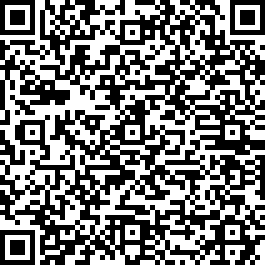

In [19]:
import qrcode
from IPython.display import Image 

qr = qrcode.QRCode(version=1, box_size=5, border=0)
qr.add_data(url)
qr.make(fit=True)

img = qr.make_image(fill='black', back_color='white')
qr_filename = 'qr-{0}.png'.format(ikof)
img.save(qr_filename)

Image(qr_filename)